<a href="https://colab.research.google.com/github/modobasic/Racunalni-vid---projekt/blob/main/Multiscale_Morphological_Gland_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/modobasic/Racunalni-vid---projekt/blob/main/Multiscale_Morphological_Gland_Segmentation.ipynb)

In [2]:
!mkdir -p data
!unzip archive.zip -d data
!ls data



Archive:  archive.zip
  inflating: data/Warwick_QU_Dataset/Grade.csv  
  inflating: data/Warwick_QU_Dataset/testA_1.bmp  
  inflating: data/Warwick_QU_Dataset/testA_10.bmp  
  inflating: data/Warwick_QU_Dataset/testA_10_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_11.bmp  
  inflating: data/Warwick_QU_Dataset/testA_11_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_12.bmp  
  inflating: data/Warwick_QU_Dataset/testA_12_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_13.bmp  
  inflating: data/Warwick_QU_Dataset/testA_13_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_14.bmp  
  inflating: data/Warwick_QU_Dataset/testA_14_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_15.bmp  
  inflating: data/Warwick_QU_Dataset/testA_15_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_16.bmp  
  inflating: data/Warwick_QU_Dataset/testA_16_anno.bmp  
  inflating: data/Warwick_QU_Dataset/testA_17.bmp  
  inflating: data/Warwick_QU_Dataset/testA_17_anno.bmp  
  infl

In [3]:
import os, glob, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATA_DIR = "data/Warwick_QU_Dataset"

def find_pairs(folder):
    files = glob.glob(folder + "/*.bmp")
    images = [f for f in files if not f.endswith("_anno.bmp")]
    pairs = []
    for img in images:
        mask = img.replace(".bmp", "_anno.bmp")
        if os.path.exists(mask):
            pairs.append((img, mask))
    return sorted(pairs)

pairs = find_pairs(DATA_DIR)
print("Broj parova (slika+maska):", len(pairs))
print("Primjer:", os.path.basename(pairs[0][0]), "|", os.path.basename(pairs[0][1]))


Broj parova (slika+maska): 165
Primjer: testA_1.bmp | testA_1_anno.bmp


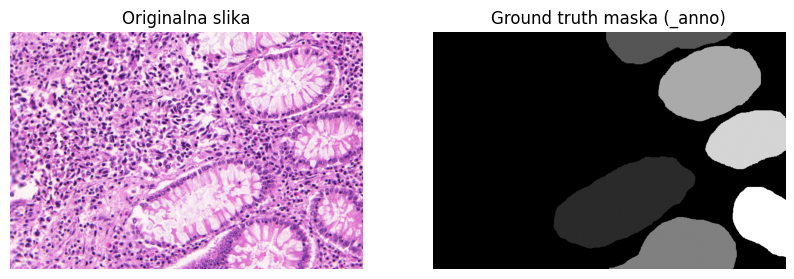

Odabrano: train_4.bmp


In [4]:
img_path, mask_path = random.choice(pairs)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Originalna slika")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground truth maska (_anno)")
plt.axis("off")
plt.show()

print("Odabrano:", os.path.basename(img_path))


In [6]:
def preprocess(img):
    # Pretvori u sivu sliku
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Malo zamuti da se smanji šum
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Automatski prag (Otsu)
    _, binary = cv2.threshold(blur, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ako je bijelo = pozadina, invertiraj
    if np.mean(binary) > 127:
        binary = cv2.bitwise_not(binary)

    return binary


In [7]:
def multiscale(binary, scales=[3, 7, 15]):
    combined = np.zeros_like(binary)
    results = {}

    for s in scales:
        # Strukturni element (kernel)
        kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (s, s)
        )

        # Otvaranje = uklanja male smetnje
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        # Zatvaranje = zatvara rupe u žlijezdama
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

        results[s] = closed

        # Spoji sa zajedničkom maskom
        combined = cv2.bitwise_or(combined, closed)

    return combined, results


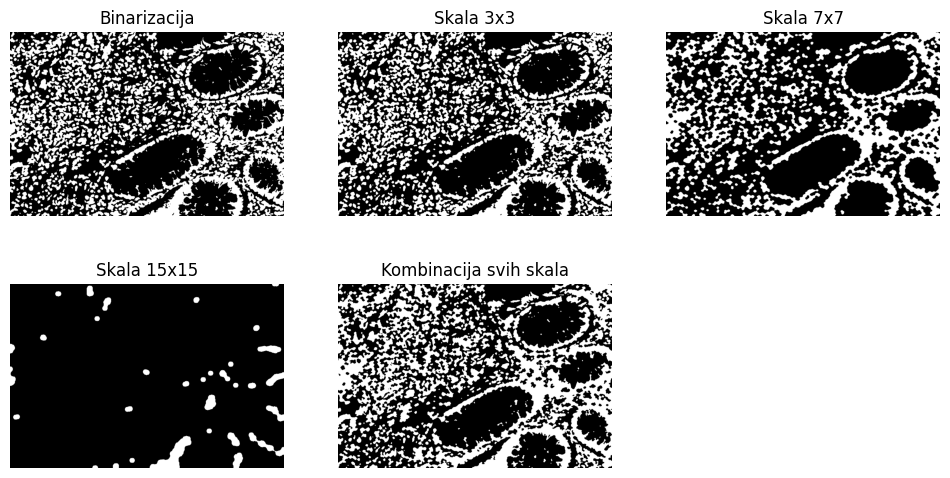

In [8]:
img = cv2.imread(img_path)
binary = preprocess(img)

final_mask, per_scale = multiscale(binary, [3, 7, 15])

plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.imshow(binary, cmap="gray")
plt.title("Binarizacija")
plt.axis("off")

i = 2
for s in per_scale:
    plt.subplot(2,3,i)
    plt.imshow(per_scale[s], cmap="gray")
    plt.title(f"Skala {s}x{s}")
    plt.axis("off")
    i += 1

plt.subplot(2,3,i)
plt.imshow(final_mask, cmap="gray")
plt.title("Kombinacija svih skala")
plt.axis("off")

plt.show()


In [9]:
def iou(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union

def dice(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())


In [10]:
configs = [
    (3,),
    (7,),
    (15,),
    (3, 7, 15)
]

for scales in configs:
    ious = []
    dices = []

    for img_path, mask_path in random.sample(pairs, 10):
        img = cv2.imread(img_path)
        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        binary = preprocess(img)
        pred, _ = multiscale(binary, list(scales))

        ious.append(iou(pred, gt))
        dices.append(dice(pred, gt))

    print("Skale:", scales)
    print("Prosječni IoU :", round(np.mean(ious), 3))
    print("Prosječni Dice:", round(np.mean(dices), 3))
    print("------------")


Skale: (3,)
Prosječni IoU : 0.316
Prosječni Dice: 0.469
------------
Skale: (7,)
Prosječni IoU : 0.232
Prosječni Dice: 0.365
------------
Skale: (15,)
Prosječni IoU : 0.276
Prosječni Dice: 0.419
------------
Skale: (3, 7, 15)
Prosječni IoU : 0.316
Prosječni Dice: 0.464
------------
